## Segmentation: Unsupervised Clustering Methods for Exploring Subpopulations

The general goal of market segmentation is to ﬁnd groups of customers that differ in important ways that are associated with
product interest, market participation, or response to marketing efforts. By understanding the differences among groups, a
marketer can make better strategic choices about opportunities, product deﬁnition, and positioning, and can engage in more
effective promotion.

In [45]:
import pandas as pd
seg_df = pd.read_csv('data/003_segments.csv')
seg_df.head()

,Segment,age,gender,income,kids,own_home,subscribe
0,travelers,60.794945,male,57014.537526,0,True,False
1,travelers,61.764535,female,43796.941252,0,False,False
2,travelers,47.493356,male,51095.344683,0,True,False
3,travelers,60.963694,male,56457.722237,0,True,True
4,travelers,60.594199,female,103020.070798,0,True,False


In [46]:
# The original dataset seg_df contains known segment assignments that have been provided for the
# data. Because our task here is to discover segments, we create a copy seg_sub that omits those 
# assignments.

seg_df['is_female'] = seg_df.gender == 'female'
seg_sub = seg_df.drop(['Segment', 'gender'], axis=1)
seg_sub.head()

,age,income,kids,own_home,subscribe,is_female
0,60.794945,57014.537526,0,True,False,False
1,61.764535,43796.941252,0,False,False,True
2,47.493356,51095.344683,0,True,False,False
3,60.963694,56457.722237,0,True,True,False
4,60.594199,103020.070798,0,True,False,True


In [47]:
# Additionally, distance-based clustering approaches are sensitive to the scale of the variables. A
# change of 10 is relatively insignificant in income, but quite significant in the number of
# children! However, the distance metric would treat those equally.
from sklearn import preprocessing

seg_sc = pd.DataFrame(preprocessing.scale(seg_sub),
                      columns=seg_sub.columns)
seg_sc.head()

,age,income,kids,own_home,subscribe,is_female
0,1.551729,0.328689,-0.902199,1.120553,-0.363422,-0.960769
1,1.627442,-0.356010,-0.902199,-0.892416,-0.363422,1.040833
2,0.513037,0.022062,-0.902199,1.120553,-0.363422,-0.960769
3,1.564906,0.299844,-0.902199,1.120553,2.751623,-0.960769
4,1.536053,2.711871,-0.902199,1.120553,-0.363422,1.040833


### Check function

In [48]:
pd.pivot_table(seg_sub, index=seg_df.Segment)

,age,income,is_female,kids,own_home,subscribe
Segment,,,,,,
moving_up,36.216087,51763.552666,0.700,1.857143,0.357143,0.214286
suburb_mix,39.284730,55552.282925,0.530,1.950000,0.480000,0.070000
travelers,57.746500,62609.655328,0.325,0.000000,0.662500,0.025000
urban_hip,23.873716,20267.737317,0.320,1.140000,0.140000,0.220000


In [49]:
import numpy as np

pd.pivot_table(seg_sub, index=seg_df.Segment,
               aggfunc=[np.mean, np.std]).unstack()

                 Segment   
mean  age        moving_up        36.216087
                 suburb_mix       39.284730
                 travelers        57.746500
                 urban_hip        23.873716
      income     moving_up     51763.552666
                 suburb_mix    55552.282925
                 travelers     62609.655328
                 urban_hip     20267.737317
      is_female  moving_up         0.700000
                 suburb_mix        0.530000
                 travelers         0.325000
                 urban_hip         0.320000
      kids       moving_up         1.857143
                 suburb_mix        1.950000
                 travelers         0.000000
                 urban_hip         1.140000
      own_home   moving_up         0.357143
                 suburb_mix        0.480000
                 travelers         0.662500
                 urban_hip         0.140000
      subscribe  moving_up         0.214286
                 suburb_mix        0.070000
    

In [50]:
pd.pivot_table(seg_sub, index=seg_df.Segment,
               aggfunc=lambda x: np.percentile(x, 95))

,age,income,is_female,kids,own_home,subscribe
Segment,,,,,,
moving_up,43.273817,63948.927421,1.0,4.55,1.0,1.0
suburb_mix,47.476484,74814.773225,1.0,4.05,1.0,1.0
travelers,73.252981,96231.113850,1.0,0.00,1.0,0.0
urban_hip,26.871298,27540.504213,1.0,2.55,1.0,1.0


In [51]:
def check_clusters(data, labels):
  return pd.pivot_table(data,
                        index=labels)

check_clusters(seg_sub, seg_df.Segment)

,age,income,is_female,kids,own_home,subscribe
Segment,,,,,,
moving_up,36.216087,51763.552666,0.700,1.857143,0.357143,0.214286
suburb_mix,39.284730,55552.282925,0.530,1.950000,0.480000,0.070000
travelers,57.746500,62609.655328,0.325,0.000000,0.662500,0.025000
urban_hip,23.873716,20267.737317,0.320,1.140000,0.140000,0.220000


### Hierarchical clustering and distances

In [52]:
from scipy.spatial import distance

In [53]:
# Distance matrix: the distance between the second and third variable is 3.07 (Euclidean distance).
distance.squareform(distance.pdist(seg_sc.iloc[:3]))

array([[0.        , 2.92113022, 1.08300539],
       [2.92113022, 0.        , 3.07299428],
       [1.08300539, 3.07299428, 0.        ]])

In [54]:
# Notice that the square-form distance matrix has a lot of redundant information, which we can 
# remove to make it more memory efficient, but is harder for a human to inspect.
distance.pdist(seg_sc.iloc[:3])

array([2.92113022, 1.08300539, 3.07299428])

In [55]:
from scipy.cluster import hierarchy

linkages = hierarchy.linkage(seg_sc, method='ward')

### Hierarchical Clustering
Hierarchical clustering groups observations according to their similarity.

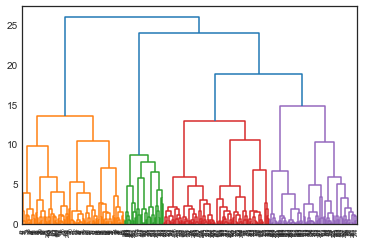

In [56]:
# Resulting tree for all N = 300 observations.
# At the lowest level of the tree we see that elements are combined into small groups of 2–10 that
# are relatively similar, and then those groups are successively combined with less similar groups
# moving up the tree. The horizontal ordering of branches is not important.

# Each node at the bottom represents one customer, and the tree show how each has been grouped
# progressively with other customers.
hierarchy.dendrogram(linkages)
plt.show()

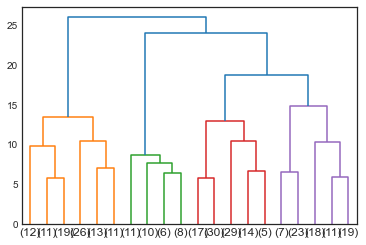

In [57]:
hierarchy.dendrogram(linkages, orientation='top',
                     truncate_mode='lastp', p=20) # p branches will be shown.
plt.show()

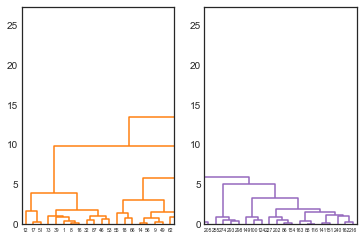

In [58]:
# Zooms into the tree with xlim.
plt.subplot(1,2,1)
hierarchy.dendrogram(linkages, leaf_rotation=0)
plt.xlim((0,200))
plt.subplot(1,2,2)
hierarchy.dendrogram(linkages, leaf_rotation=0)
plt.xlim((2800, 3000))
plt.show()

In [59]:
# Similar
seg_sub.loc[[17, 51]]

,age,income,kids,own_home,subscribe,is_female
17,73.266707,70157.058678,0,False,False,True
51,71.172291,75554.353842,0,False,False,True


In [60]:
# Dissimilar
seg_sub.loc[[163, 88]]

,age,income,kids,own_home,subscribe,is_female
163,39.653607,48996.400976,2,True,False,False
88,40.106702,41744.977842,2,True,False,False


In [61]:
# Dissimilar
seg_sub.loc[[17,163]] # Observations 17 and 163 are only joined at the highest level of the tree.

,age,income,kids,own_home,subscribe,is_female
17,73.266707,70157.058678,0,False,False,True
163,39.653607,48996.400976,2,True,False,False


In [62]:
# Goodness-of-fit metrics for a hierarchical cluster: ophenetic correlation coefficient (CPCC),
# which assesses how well the dendrogram matches the distance metric.
# CPCC is interpreted similarly to Pearson's r. In this case, CPCC is about 0.6, indicating a 
# moderately strong fit, meaning that the hierarchical tree represents the distances between 
# customers well.
hierarchy.cophenet(linkages, distance.pdist(seg_sc))[0]

0.5985290160084775

How do we get speciﬁc segment assignments? A dendrogram can be cut into clusters at any height desired, resulting in
different numbers of groups. For instance, if cut at a height of 25 there are K = 2 groups (draw a horizontal line
at 25 and count how many branches it intersects; each cluster below is a group), while cutting at height of 9 defines K = 11
groups.

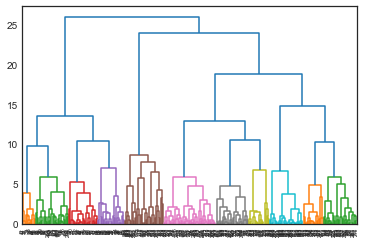

In [63]:
# Not shown
# color_threshold argument, which will color only the branches below that threshold.
hierarchy.dendrogram(linkages, color_threshold=9)
plt.show()

In [64]:
labels = hierarchy.fcluster(linkages, t=4, criterion='maxclust') # t=4: we expect 4 clusters.
list(zip(*np.unique(labels, return_counts=True)))

# Returns [(cluster label, observation count per cluster), ...]
# We see that groups 1, 3, and 4 are similar in size while group 2 is less than half the size of the
# others. Note that the class labels (1, 2, 3, 4) are in arbitrary order and are not meaningful in
# themselves.

[(1, 92), (2, 35), (3, 95), (4, 78)]

In [65]:
check_clusters(seg_sub, labels)

,age,income,is_female,kids,own_home,subscribe
1,54.474706,63219.658293,0.250000,0.152174,0.521739,0.0
2,34.523881,41685.199147,0.542857,1.514286,0.314286,1.0
3,38.204641,51578.802282,1.000000,1.873684,0.463158,0.0
4,31.122503,38790.506683,0.089744,1.756410,0.384615,0.0


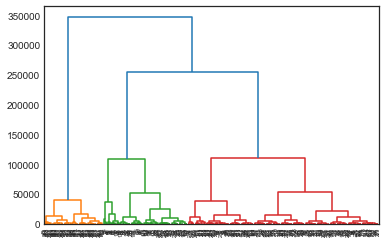

In [66]:
linkages_unscaled = hierarchy.linkage(seg_sub, method='ward')
hierarchy.dendrogram(linkages_unscaled)
plt.show()

In [67]:
# We see that 3 clusters are more appropriate than 4.
labels_unscaled = hierarchy.fcluster(linkages_unscaled, t=3,
                                     criterion='maxclust')
check_clusters(seg_sub, labels_unscaled)

,age,income,is_female,kids,own_home,subscribe
1,26.238778,20026.508497,0.320755,1.113208,0.150943,0.207547
2,48.102952,74464.263260,0.394737,1.052632,0.500000,0.052632
3,42.283774,49591.504755,0.567251,1.421053,0.508772,0.116959


In [68]:
def cluster_plot_raw(x, y, labels):
  for l in np.unique(labels):
    idx = labels == l
    plt.scatter(x[idx],
                y[idx],
                label=l)
  plt.legend()
  plt.xlabel(x.name)
  plt.ylabel(y.name)

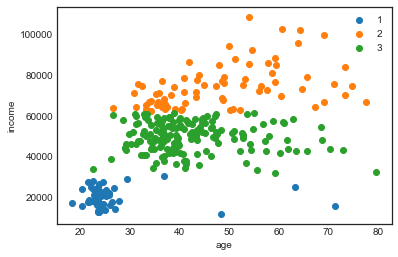

In [69]:
# Plotting the 3-segment hierarchical solution from the unscaled segmentation data by age and income,
# with color representing segment membership. We see that the clustering appears to be defined
# primarily by income.
cluster_plot_raw(seg_sub.age, seg_sub.income, labels_unscaled)

### Mean-based clustering: K-*means*

In [70]:
def check_clusters(data, labels):
  print(list(zip(*np.unique(labels, return_counts=True))))
  
  return pd.pivot_table(data,
                        index=labels)

In [71]:
import numpy as np
from sklearn import cluster

np.random.seed(536)
centroids, labels, inertia = cluster.k_means(seg_sc, n_clusters=4)
check_clusters(seg_sub, labels)

[(0, 35), (1, 89), (2, 104), (3, 72)]


,age,income,is_female,kids,own_home,subscribe
0,34.523881,41685.199147,0.542857,1.514286,0.314286,1.0
1,54.862339,64589.811960,0.235955,0.157303,0.662921,0.0
2,37.599396,49388.603148,1.000000,1.759615,0.394231,0.0
3,31.605330,39679.809850,0.000000,1.833333,0.305556,0.0


In [72]:
centroids, k_labels_unscaled4, inertia = cluster.k_means(seg_sub,
                                                         n_clusters=4)
check_clusters(seg_sub, k_labels_unscaled4)

[(0, 55), (1, 96), (2, 107), (3, 42)]


,age,income,is_female,kids,own_home,subscribe
0,27.809087,20457.938690,0.327273,1.072727,0.163636,0.200000
1,42.346106,60157.505981,0.541667,1.625000,0.447917,0.093750
2,41.993915,45566.356272,0.570093,1.373832,0.532710,0.130841
3,52.117381,81545.927332,0.309524,0.476190,0.571429,0.023810


In [73]:
centroids, k_labels_unscaled3, inertia = cluster.k_means(seg_sub,
                                                         n_clusters=3)
check_clusters(seg_sub, k_labels_unscaled3)

[(0, 61), (1, 64), (2, 175)]


,age,income,is_female,kids,own_home,subscribe
0,49.909555,77186.085839,0.377049,0.852459,0.491803,0.049180
1,29.635597,22520.530838,0.343750,1.109375,0.171875,0.187500
2,41.919108,51720.977493,0.565714,1.480000,0.525714,0.114286


Text(0.5, 0.98, '')

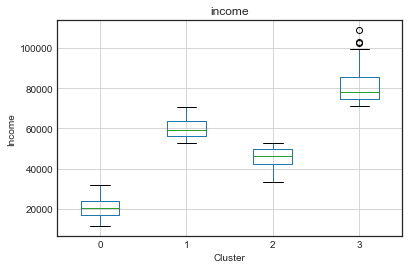

In [74]:
# Boxplot of income by cluster as found with k_means().
import matplotlib.pyplot as plt
seg_sub.boxplot(column='income', by=k_labels_unscaled4)
plt.xlabel('Cluster')
plt.ylabel('Income')
plt.suptitle('') # Remove cluster id subtitle

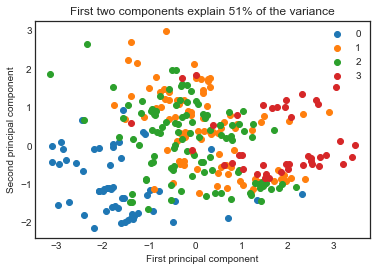

In [75]:
from sklearn import decomposition
from matplotlib import cm

def cluster_plot(data_df, labels):
  p = decomposition.PCA(random_state=132, svd_solver='full')
  scaled_transformed = p.fit_transform(preprocessing.scale(data_df))
  for l in np.unique(labels):
    idx = np.where(labels == l)[0]
    plt.scatter(scaled_transformed[idx, 0],
                scaled_transformed[idx, 1],
                label=l)
  plt.legend()
  plt.title('First two components explain {}% of the variance'
            .format(round(100*p.explained_variance_ratio_[:2].sum())))
  plt.xlabel('First principal component')
  plt.ylabel('Second principal component')

cluster_plot(seg_sub, k_labels_unscaled4)

# This may suggest a business strategy. In the present case, for instance, we see that group 3 is 
# modestly well-differentiated, and has the highest average income. That may make it a good target 
# for a potential campaign. Or we might focus on group 0 as our segment with the highest subscription
# rate and understand how to grow our market there. Many other strategies are possible, too; the key 
# point is that the analysis provides interesting options to consider.

### Model-based clustering: Gaussian Mixture Models
The key idea for model-based clustering is that observations come from groups with different statistical distributions (such as
different means and variances). The algorithms try to find the best set of such underlying distributions to explain the observed
data.

In [76]:
from sklearn import mixture

gmm4 = mixture.GaussianMixture(n_components=4,
                              covariance_type='full',
                              random_state=323).fit(seg_sub)
gmm4_labels = gmm4.predict(seg_sub)
gmm4.bic(seg_sub)

7892.76042330893

In [77]:
check_clusters(seg_sub, gmm4_labels)

[(0, 21), (1, 3), (2, 11), (3, 265)]


,age,income,is_female,kids,own_home,subscribe
0,39.691199,49447.312310,0.571429,1.476190,0.476190,1.0
1,39.579480,68853.390277,0.333333,3.000000,0.000000,1.0
2,23.280202,19457.112800,0.545455,1.181818,0.090909,1.0
3,41.768562,51856.053966,0.471698,1.241509,0.460377,0.0


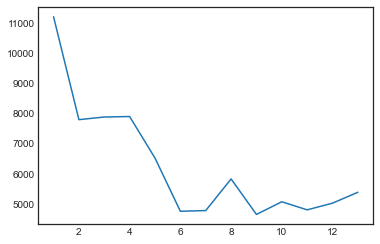

In [78]:
# BIC values of GaussianMixture() models as a function of the number of components. Model fit does
# not improve beyond five components until we get to ten components, which is likely too many to 
# interpret effectively. Lower BIC values mean a better model fit.
gmm_n_test = [mixture.GaussianMixture(n_components=n,
                                      covariance_type='full',
                                      random_state=323)
                       .fit(seg_sub) for n in range(1,14)]
plt.plot(range(1, 14), [g.bic(seg_sub) for g in gmm_n_test])

<AxesSubplot:>

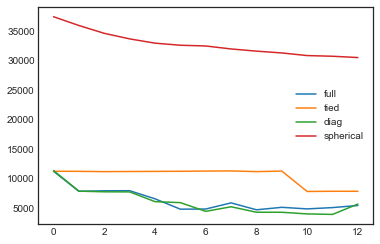

In [79]:
# BIC values of GaussianMixture() models as a function of the number of components and covariance
# type. Diagonal and full covariance provide the best fits.
gmm_n_v_test = {v: [mixture.GaussianMixture(n_components=n,
                                        covariance_type=v,
                                        random_state=323)
                       .fit(seg_sub) for n in range(1,14)]
                for v in ['full', 'tied', 'diag', 'spherical']}
gmm_n_v_test_bic = {v: [g.bic(seg_sub) for g in m]
                    for v, m in gmm_n_v_test.items()}
pd.DataFrame(gmm_n_v_test_bic).plot()

<AxesSubplot:>

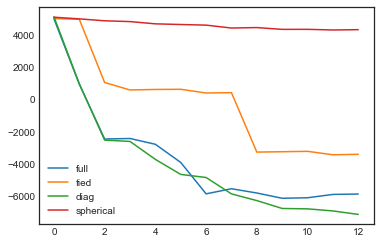

In [80]:
gmm_n_v_test = {v: [mixture.GaussianMixture(n_components=n,
                                        covariance_type=v,
                                        random_state=323)
                       .fit(seg_sc) for n in range(1,14)]
                for v in ['full', 'tied', 'diag', 'spherical']}
gmm_n_v_test_bic = {v: [g.bic(seg_sc) for g in m]
                    for v, m in gmm_n_v_test.items()}
pd.DataFrame(gmm_n_v_test_bic).plot()

In [81]:
gmm5 = mixture.GaussianMixture(n_components=5,
                               covariance_type='diag',
                               random_state=323).fit(seg_sub)
gmm5_labels = gmm5.predict(seg_sub)

In [82]:
check_clusters(seg_sub, gmm5_labels)

[(0, 4), (1, 129), (2, 32), (3, 114), (4, 21)]


,age,income,is_female,kids,own_home,subscribe
0,52.523755,44005.211404,0.000000,0.500000,1.000000,1.0000
1,37.366073,52743.873543,0.581395,2.248062,0.465116,0.0000
2,23.630276,20251.707688,0.375000,1.593750,0.000000,0.3125
3,50.212110,56931.154434,0.385965,0.000000,0.543860,0.0000
4,36.492245,51554.737478,0.619048,1.857143,0.333333,1.0000


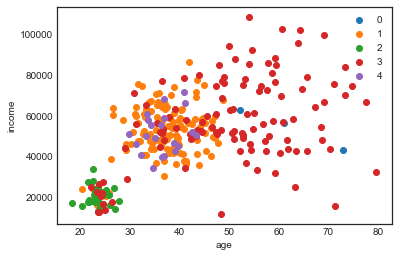

In [83]:
cluster_plot_raw(seg_sub.age, seg_sub.income, gmm5_labels)

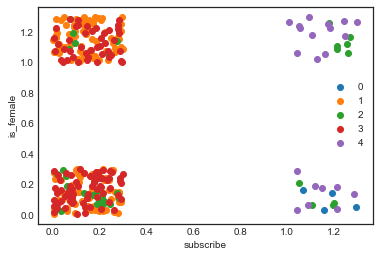

In [84]:
n_obs = seg_sub.shape[0]
cluster_plot_raw(seg_sub.subscribe + .3*np.random.rand(n_obs),
                 seg_sub.is_female + .3*np.random.rand(n_obs),
                 gmm5_labels)

These clusters do not look to be very actionable. Nearly all observations fall in either group 0 or group 4, which include
all non-subscribers. Those two groups are differentiated on a few measures, most notably children: individuals in group
4 have no children whereas those in group 0 have, on average, 2.24 children. Again, the idea that individuals with and
without children might be important segments very well may be accurate and business-relevant, but it wouldn't really take a
sophisticated clustering analysis to ﬁnd that!